## Installation

First, install the required libraries:

In [ ]:
!pip install mlcroissant torch torchvision numpy pandas matplotlib scikit-learn

## Step 1: Import Libraries

In [2]:
import mlcroissant as mlc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu128
CUDA available: True


## Step 2: Load the Croissant Dataset

Loading a Croissant dataset is straightforward - just point to the `croissant.json` file.

**Note**: Make sure you're in the correct directory or provide the full path to `croissant.json`.

In [3]:
# Path to your croissant.json file
# Adjust this path to match your dataset location
croissant_path = "./croissant_cutouts/hackathon_dataset/croissant.json"

# Alternative: Use relative path if running from repo root
# croissant_path = "croissant_cutouts/hackathon_dataset/croissant.json"

# Load the dataset
print(f"Loading dataset from: {croissant_path}")
dataset = mlc.Dataset(jsonld=croissant_path)

print("✓ Dataset loaded successfully!")
print(f"Dataset name: {dataset.metadata.name}")
print(f"Description: {dataset.metadata.description}")

Loading dataset from: ./croissant_cutouts/hackathon_dataset/croissant.json
✓ Dataset loaded successfully!
Dataset name: roman_croissant_cutouts
Description: Pre-extracted 64x64 cutouts with candidate metadata for transient classification


## Step 3: Access Records and Explore Fields

The Croissant dataset provides a record iterator. Let's load all records into a list and examine them.

In [4]:
# Get records from the dataset
# The record set ID is "transient_candidates" for RAPID datasets
records = dataset.records("transient_candidates")

# Load all records into a list (this may take a moment for large datasets)
print("Loading records...")
all_records = list(records)
print(f"✓ Loaded {len(all_records)} records")

# Examine the first record
print("\n" + "="*60)
print("Example Record (first candidate):")
print("="*60)

first_record = all_records[0]
for key, value in first_record.items():
    if isinstance(value, float):
        print(f"{key:20s}: {value:.4f}")
    else:
        print(f"{key:20s}: {value}")

Loading records...
✓ Loaded 2506 records

Example Record (first candidate):
transient_candidates/id: 1.0000
transient_candidates/x: 1300.2796
transient_candidates/y: 0.5339
transient_candidates/sharpness: 0.9270
transient_candidates/roundness1: -0.2780
transient_candidates/roundness2: 0.2667
transient_candidates/npix: 25.0000
transient_candidates/peak: 0.3275
transient_candidates/flux: 0.1782
transient_candidates/mag: 1.8730
transient_candidates/daofind_mag: -0.1653
transient_candidates/match_id: None
transient_candidates/truth_id: None
transient_candidates/injected: False
transient_candidates/cutout_id: 0
transient_candidates/jid: b'jid12345'
transient_candidates/label: 0
transient_candidates/cutout_path: b'cutouts/jid12345_cutout00000.npy'


## Step 4: Understanding the Fields

Let's create a summary of available fields and their statistics.

In [7]:
# Convert records to DataFrame for easy analysis
df = pd.DataFrame(all_records)

print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())

print("\n" + "="*60)
print("Numerical Features Summary:")
print("="*60)
print(df.describe())

print("\n" + "="*60)
print("Label Distribution:")
print("="*60)
label_counts = df['transient_candidates/label'].value_counts()
print(f"Bogus (0): {label_counts.get(0, 0):,} samples ({label_counts.get(0, 0)/len(df)*100:.1f}%)")
print(f"Real (1):  {label_counts.get(1, 0):,} samples ({label_counts.get(1, 0)/len(df)*100:.1f}%)")

# Check for injection tracking fields if available
if 'injected' in df.columns:
    print("\n" + "="*60)
    print("Injection Tracking:")
    print("="*60)
    injected_counts = df['injected'].value_counts()
    print(f"Natural sources:  {injected_counts.get(False, 0):,}")
    print(f"Injected sources: {injected_counts.get(True, 0):,}")

Dataset Shape: (2506, 18)

Column Names:
['transient_candidates/id', 'transient_candidates/x', 'transient_candidates/y', 'transient_candidates/sharpness', 'transient_candidates/roundness1', 'transient_candidates/roundness2', 'transient_candidates/npix', 'transient_candidates/peak', 'transient_candidates/flux', 'transient_candidates/mag', 'transient_candidates/daofind_mag', 'transient_candidates/match_id', 'transient_candidates/truth_id', 'transient_candidates/injected', 'transient_candidates/cutout_id', 'transient_candidates/jid', 'transient_candidates/label', 'transient_candidates/cutout_path']

Numerical Features Summary:
       transient_candidates/id  transient_candidates/x  \
count              2506.000000             2506.000000   
mean               1254.515164             2073.371020   
std                 723.591453             1214.536509   
min                   1.000000                2.791800   
25%                 628.250000             1138.293325   
50%                1

## Step 5: Load and Visualize Image Tensors

Each record has a `cutout_path` field pointing to a 64x64x4 NumPy tensor.

The 4 channels are:
1. **Science image** (channel 0)
2. **Reference image** (channel 1)
3. **Difference image** (channel 2)
4. **SCORR image** (channel 3)

In [12]:
def load_cutout(record, base_path="./croissant_cutouts/hackathon_dataset"):
    """
    Load a cutout tensor from a record.
    
    Args:
        record: A single record from the dataset
        base_path: Base path where the dataset is located
    
    Returns:
        numpy array of shape (64, 64, 4)
    """
    temp_path = record['transient_candidates/cutout_path'].decode('utf-8')
    cutout_path = os.path.join(base_path, temp_path)
    return np.load(cutout_path)

# Load a few examples
print("Loading sample cutouts...")
sample_records = all_records[:5]  # First 5 records

for i, record in enumerate(sample_records):
    cutout = load_cutout(record)
    print(f"Record {i}: Shape={cutout.shape}, Label={record['transient_candidates/label']}, "
          f"Mag={record['transient_candidates/mag']:.2f}, JID={record['transient_candidates/jid']}")

Loading sample cutouts...
Record 0: Shape=(64, 64, 4), Label=0, Mag=1.87, JID=b'jid12345'
Record 1: Shape=(64, 64, 4), Label=0, Mag=-1.04, JID=b'jid12345'
Record 2: Shape=(64, 64, 4), Label=0, Mag=0.88, JID=b'jid12345'
Record 3: Shape=(64, 64, 4), Label=0, Mag=-0.04, JID=b'jid12345'
Record 4: Shape=(64, 64, 4), Label=0, Mag=-1.11, JID=b'jid12345'


### Visualize Sample Cutouts

Visualizing samples...

Real Transient Example:


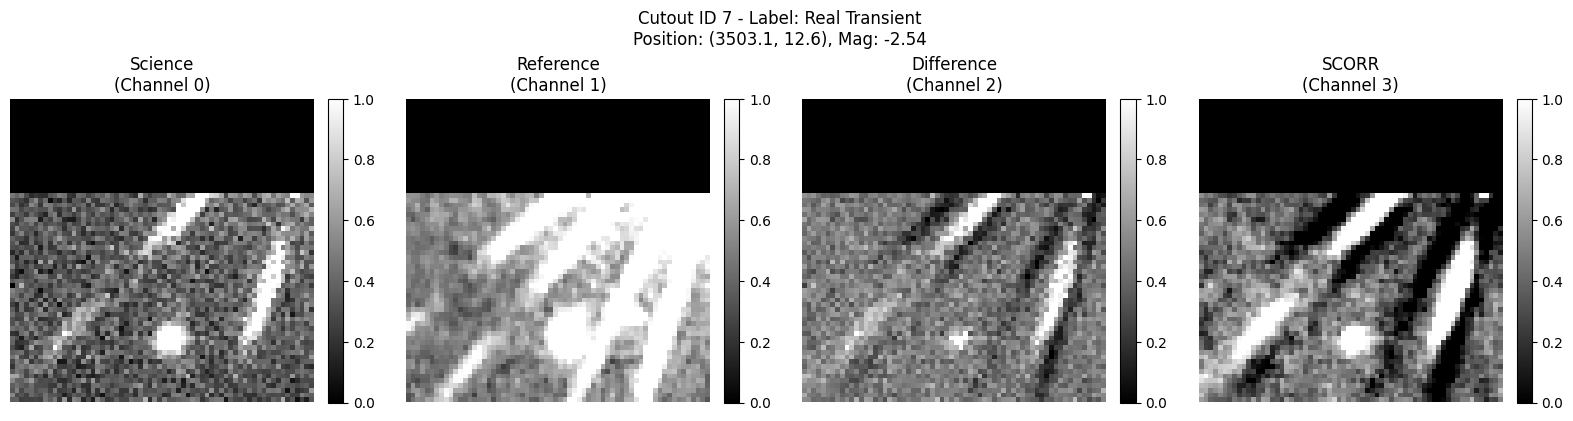


Bogus Detection Example:


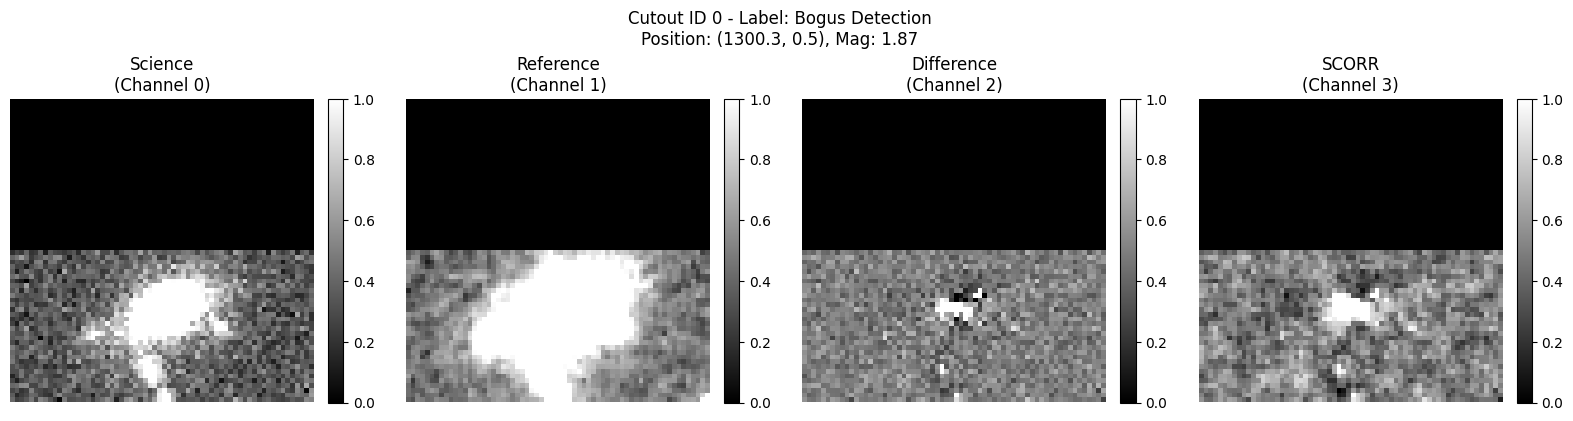

In [14]:
def visualize_cutout(record, base_path="./croissant_cutouts/hackathon_dataset"):
    """
    Visualize all 4 channels of a cutout.
    """
    cutout = load_cutout(record, base_path)
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    channel_names = ['Science', 'Reference', 'Difference', 'SCORR']
    
    for i, (ax, name) in enumerate(zip(axes, channel_names)):
        im = ax.imshow(cutout[:, :, i], cmap='gray', origin='lower')
        ax.set_title(f"{name}\n(Channel {i})")
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    label_text = "Real Transient" if record['transient_candidates/label'] == 1 else "Bogus Detection"
    plt.suptitle(f"Cutout ID {record['transient_candidates/cutout_id']} - Label: {label_text}\n"
                 f"Position: ({record['transient_candidates/x']:.1f}, {record['transient_candidates/y']:.1f}), Mag: {record['transient_candidates/mag']:.2f}",
                 fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

# Visualize one real and one bogus example
print("Visualizing samples...\n")

# Find one real transient
real_record = next(r for r in all_records if r['transient_candidates/label'] == 1)
print("Real Transient Example:")
visualize_cutout(real_record)

# Find one bogus detection
bogus_record = next(r for r in all_records if r['transient_candidates/label'] == 0)
print("\nBogus Detection Example:")
visualize_cutout(bogus_record)

## Step 6: Create PyTorch Dataset

Now let's create a PyTorch Dataset class to efficiently load the data during training.

In [25]:
class CroissantCutoutsDataset(Dataset):
    """
    PyTorch Dataset for Croissant cutouts.
    """
    def __init__(self, records, base_path="./croissant_cutouts/hackathon_dataset", transform=None):
        """
        Args:
            records: List of records from Croissant dataset
            base_path: Base path where cutouts are stored
            transform: Optional transform to apply to images
        """
        self.records = records
        self.base_path = base_path
        self.transform = transform
    
    def __len__(self):
        return len(self.records)
    
    def __getitem__(self, idx):
        record = self.records[idx]
        
        # Load cutout tensor (64, 64, 4)
        temp_path = record['transient_candidates/cutout_path'].decode('utf-8')
        cutout_path = os.path.join(self.base_path, temp_path)
        cutout = np.load(cutout_path).astype(np.float32)
        
        # Convert to PyTorch tensor and change from (H, W, C) to (C, H, W)
        cutout = torch.from_numpy(cutout).permute(2, 0, 1)
        
        # Apply transforms if any
        if self.transform:
            cutout = self.transform(cutout)
        
        # Get label
        label = torch.tensor(record['transient_candidates/label'], dtype=torch.long)
        
        return cutout, label

print("PyTorch Dataset class defined")

PyTorch Dataset class defined


## Step 7: Split Data into Train/Val/Test Sets

In [26]:
# Split data: 70% train, 15% validation, 15% test
train_records, temp_records = train_test_split(all_records, test_size=0.3, random_state=42, 
                                                 stratify=[r['transient_candidates/label'] for r in all_records])
val_records, test_records = train_test_split(temp_records, test_size=0.5, random_state=42,
                                               stratify=[r['transient_candidates/label'] for r in temp_records])

print(f"Train set: {len(train_records)} samples")
print(f"Val set:   {len(val_records)} samples")
print(f"Test set:  {len(test_records)} samples")

# Create PyTorch datasets
train_dataset = CroissantCutoutsDataset(train_records)
val_dataset = CroissantCutoutsDataset(val_records)
test_dataset = CroissantCutoutsDataset(test_records)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\nBatch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")

Train set: 1754 samples
Val set:   376 samples
Test set:  376 samples

Batch size: 32
Train batches: 55
Val batches:   12
Test batches:  12


## Step 8: Define a Simple 3-Layer CNN

We'll create a simple convolutional neural network with:
- 3 convolutional layers with ReLU activation and max pooling
- 2 fully connected layers
- Binary classification output

In [27]:
class SimpleCNN(nn.Module):
    """
    Simple 3-layer CNN for transient classification.
    
    Architecture:
    - Conv1: 4 -> 32 channels, 3x3 kernel
    - Conv2: 32 -> 64 channels, 3x3 kernel
    - Conv3: 64 -> 128 channels, 3x3 kernel
    - FC1: Flattened features -> 256
    - FC2: 256 -> 2 (binary classification)
    """
    def __init__(self, input_channels=4, num_classes=2):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
        
        # Calculate size after convolutions and pooling
        # Input: 64x64, after 3 pooling layers: 64/2/2/2 = 8x8
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        # Activation
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Conv block 1
        x = self.relu(self.conv1(x))
        x = self.pool(x)  # 64x64 -> 32x32
        
        # Conv block 2
        x = self.relu(self.conv2(x))
        x = self.pool(x)  # 32x32 -> 16x16
        
        # Conv block 3
        x = self.relu(self.conv3(x))
        x = self.pool(x)  # 16x16 -> 8x8
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(input_channels=4, num_classes=2).to(device)

print("✓ Model created")
print(f"Device: {device}")
print(f"\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

✓ Model created
Device: cuda

Model architecture:
SimpleCNN(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
)

Total parameters: 2,191,458
Trainable parameters: 2,191,458


## Step 9: Training Setup

In [28]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

print("✓ Training setup complete")
print(f"Loss function: Cross-Entropy")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Scheduler: ReduceLROnPlateau")

✓ Training setup complete
Loss function: Cross-Entropy
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau


## Step 10: Training Loop

In [31]:
def train_epoch(model, loader, criterion, optimizer, device):
    """
    Train for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    """
    Validate the model.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels


# Training loop
num_epochs = 10
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("Starting training...\n")
print("="*70)

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    # Record history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    print("-"*70)

print("\n✓ Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training...



Epoch [1/10]
  Train Loss: 0.1434 | Train Acc: 96.86%
  Val Loss:   0.1500 | Val Acc:   96.81%
  LR: 0.001000
----------------------------------------------------------------------
Epoch [2/10]
  Train Loss: 0.1361 | Train Acc: 96.86%
  Val Loss:   0.1310 | Val Acc:   96.81%
  LR: 0.001000
----------------------------------------------------------------------
Epoch [3/10]
  Train Loss: 0.1314 | Train Acc: 96.86%
  Val Loss:   0.1546 | Val Acc:   96.81%
  LR: 0.001000
----------------------------------------------------------------------
Epoch [4/10]
  Train Loss: 0.1336 | Train Acc: 96.86%
  Val Loss:   0.1300 | Val Acc:   96.81%
  LR: 0.001000
----------------------------------------------------------------------
Epoch [5/10]
  Train Loss: 0.1358 | Train Acc: 96.86%
  Val Loss:   0.1270 | Val Acc:   96.81%
  LR: 0.001000
----------------------------------------------------------------------
Epoch [6/10]
  Train Loss: 0.1334 | Train Acc: 96.86%
  Val Loss:   0.1444 | Val Acc:   96.81%


## Step 11: Plot Training History

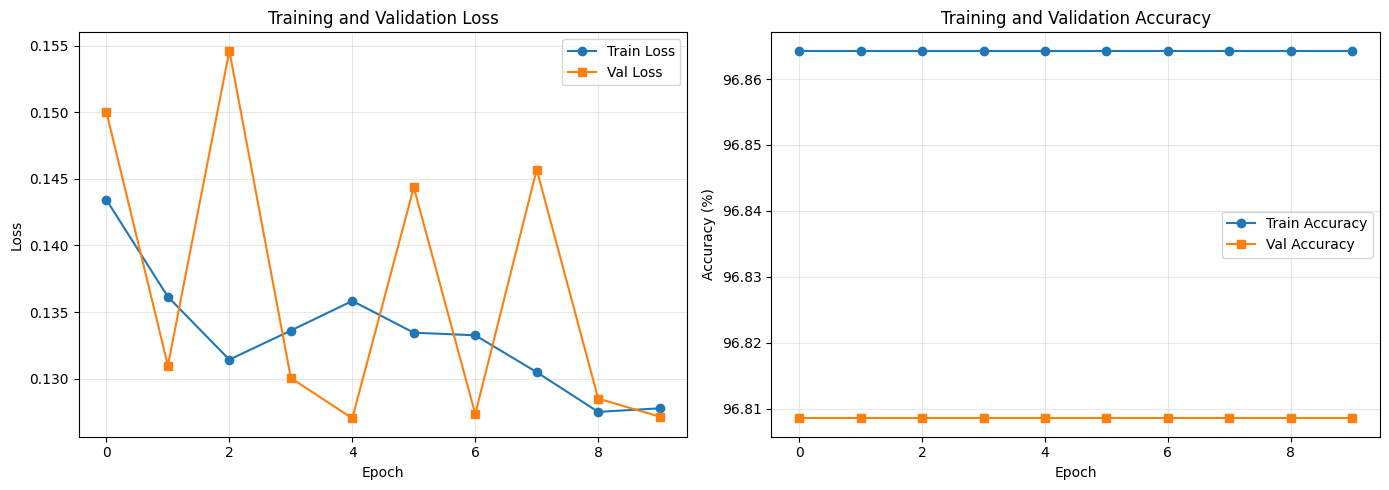

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(val_losses, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(train_accs, label='Train Accuracy', marker='o')
ax2.plot(val_accs, label='Val Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 12: Evaluate on Test Set

In [36]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, device)

print("="*70)
print("Test Set Results:")
print("="*70)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print()

# Calculate detailed metrics
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print()

Test Set Results:
Test Loss:     0.1191
Test Accuracy: 96.81%

Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000



/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Step 13: Visualize Confusion Matrix

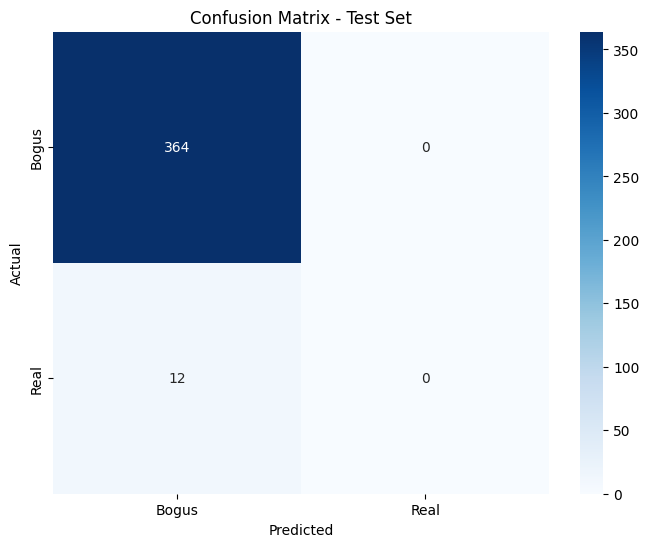

In [35]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bogus', 'Real'],
            yticklabels=['Bogus', 'Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Test Set')
plt.show()

## Summary

In this notebook, we demonstrated:

1. **Loading a Croissant dataset** - Simple one-liner with `mlcroissant`
2. **Accessing dataset fields** - Easy exploration of metadata and features
3. **Loading and visualizing images** - 4-channel cutouts visualization
4. **Creating PyTorch Dataset** - Custom dataset class for efficient loading
5. **Building a CNN classifier** - Simple 3-layer architecture
6. **Training the model** - Complete training loop with validation
7. **Evaluation** - Test set metrics and confusion matrix

## Next Steps

To improve the model, you could:
- Add data augmentation (flips, rotations)
- Use a deeper architecture (ResNet, EfficientNet)
- Incorporate photometric features as additional inputs
- Apply class balancing techniques
- Use ensemble methods
- Experiment with different loss functions (focal loss, weighted cross-entropy)

## Key Takeaway

**The Croissant format makes dataset loading easy!** Once you have the `croissant.json` file, you can focus on modeling rather than data engineering.